In [1]:
import sys, time, cProfile, pstats, importlib, os, itertools
sys.path.insert(0,'/home/uq/apps/muq2inst/lib')
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 10.)
matplotlib.rcParams.update({'font.size': 22})

import pymuqUtilities as mu

import plotutil

from GaussianPosterior import *
from DeepTransportMap import *

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
alphas = [1, .8, .6, .4, .2] 

def plot_results(sigmas, eps_Ls, results_l2, results_st, results_et) :
    fig = plt.figure()
    #fig.suptitle('noise = {}'.format(noise), fontsize=20)
    
    label = lambda eps_L : r'$|\Lambda|=$' + str(multis[eps_L[0]].Size()) + ', L={} (#f={})'.format(eps_L[1], int(np.ceil((eps_L[1]+1)*10*multis[eps_L[0]].Size()*np.log(multis[eps_L[0]].Size()))))
    kwrgs = lambda eps_L : {'color' : colors[eps_L[0]], 'lw' : 2*(eps_L[1]+1), 'alpha' : alphas[eps_L[1]]}

    ax = plotutil.get_ax(fig, 3, 1, title='L2 error', xlabel=r'$\sigma$', logaxis=['x', 'y'])
    for i in range(len(eps_Ls)) :
        ax.errorbar(sigmas, np.mean(results_l2[i], axis=1), yerr=np.std(results_l2[i], axis=1), capsize=5, label=label(eps_Ls[i]), **kwrgs(eps_Ls[i]))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 2, title='setup time', xlabel=r'$\sigma$', ylabel='error*time', logaxis=['x', 'y'])
    for i in range(len(eps_Ls)) :
        ax.plot(sigmas, np.mean(results_l2[i], axis=1) * np.mean(results_st[i], axis=1), label=label(eps_Ls[i]), **kwrgs(eps_Ls[i]))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 3, title='eval time', xlabel=r'$\sigma$', ylabel='error*time', logaxis=['x', 'y'])
    for i in range(len(eps_Ls)) :
        ax.plot(sigmas, np.mean(results_l2[i], axis=1) * np.mean(results_et[i], axis=1), label=label(eps_Ls[i]), **kwrgs(eps_Ls[i]))
    ax.legend()

    plt.tight_layout()
    plt.show()

In [3]:
n_runs = 2
n_samples = 200

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

sigmas = [1.3**(-i) for i in range(5,30)]
eps_Ls = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1) ] # {multi, L}
epslns = [.08, .004, .0002, .000015]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]

results_l2 = np.zeros((len(eps_Ls), len(sigmas), n_runs))
results_st = np.zeros((len(eps_Ls), len(sigmas), n_runs))
results_et = np.zeros((len(eps_Ls), len(sigmas), n_runs))

def compute(indices) :
    (i,j,k) = indices
    
    target = GaussianPosterior(noise=sigmas[j] , y_measurement=[.2])
    true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
    true_target /= np.sum(true_target)
    norm = np.sqrt(np.dot(true_target, true_target))
    
    multi = multis[eps_Ls[i][0]]
    temps = [10**(-eps_Ls[i][1]+n) for n in range(eps_Ls[i][1]+1)]
    
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps, multi, 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start
    
    print('i={}, j={}, k={}, m={}, temps: {}'.format(i,j,k, multi.Size(), temps))

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(eps_Ls))[::-1], range(len(sigmas))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

i=5, j=23, k=1, m=16, temps: [0.1, 1]
i=5, j=23, k=0, m=16, temps: [0.1, 1]
i=5, j=24, k=0, m=16, temps: [0.1, 1]
i=5, j=22, k=1, m=16, temps: [0.1, 1]i=5, j=22, k=0, m=16, temps: [0.1, 1]

i=5, j=21, k=0, m=16, temps: [0.1, 1]
i=5, j=21, k=1, m=16, temps: [0.1, 1]
i=5, j=24, k=1, m=16, temps: [0.1, 1]
i=5, j=20, k=0, m=16, temps: [0.1, 1]
i=5, j=19, k=1, m=16, temps: [0.1, 1]
i=5, j=20, k=1, m=16, temps: [0.1, 1]
i=5, j=18, k=1, m=16, temps: [0.1, 1]
i=5, j=19, k=0, m=16, temps: [0.1, 1]
i=5, j=17, k=1, m=16, temps: [0.1, 1]
i=5, j=17, k=0, m=16, temps: [0.1, 1]
i=5, j=18, k=0, m=16, temps: [0.1, 1]
i=5, j=16, k=1, m=16, temps: [0.1, 1]
i=5, j=15, k=1, m=16, temps: [0.1, 1]
i=5, j=15, k=0, m=16, temps: [0.1, 1]
i=5, j=14, k=1, m=16, temps: [0.1, 1]
i=5, j=13, k=1, m=16, temps: [0.1, 1]
i=5, j=14, k=0, m=16, temps: [0.1, 1]
i=5, j=16, k=0, m=16, temps: [0.1, 1]
i=5, j=13, k=0, m=16, temps: [0.1, 1]
i=5, j=12, k=1, m=16, temps: [0.1, 1]
i=5, j=12, k=0, m=16, temps: [0.1, 1]
i=5, j=11, k

/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1
/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


i=3, j=3, k=1, m=8, temps: [0.001, 0.01, 0.1, 1]
i=3, j=2, k=1, m=8, temps: [0.001, 0.01, 0.1, 1]
i=3, j=2, k=0, m=8, temps: [0.001, 0.01, 0.1, 1]
i=3, j=1, k=1, m=8, temps: [0.001, 0.01, 0.1, 1]
i=3, j=1, k=0, m=8, temps: [0.001, 0.01, 0.1, 1]
i=2, j=24, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=24, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=23, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=23, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=22, k=1, m=8, temps: [0.01, 0.1, 1]
i=3, j=0, k=1, m=8, temps: [0.001, 0.01, 0.1, 1]
i=2, j=22, k=0, m=8, temps: [0.01, 0.1, 1]
i=3, j=0, k=0, m=8, temps: [0.001, 0.01, 0.1, 1]
i=2, j=21, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=21, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=20, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=20, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=19, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=19, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=18, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=18, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=17, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=17, k

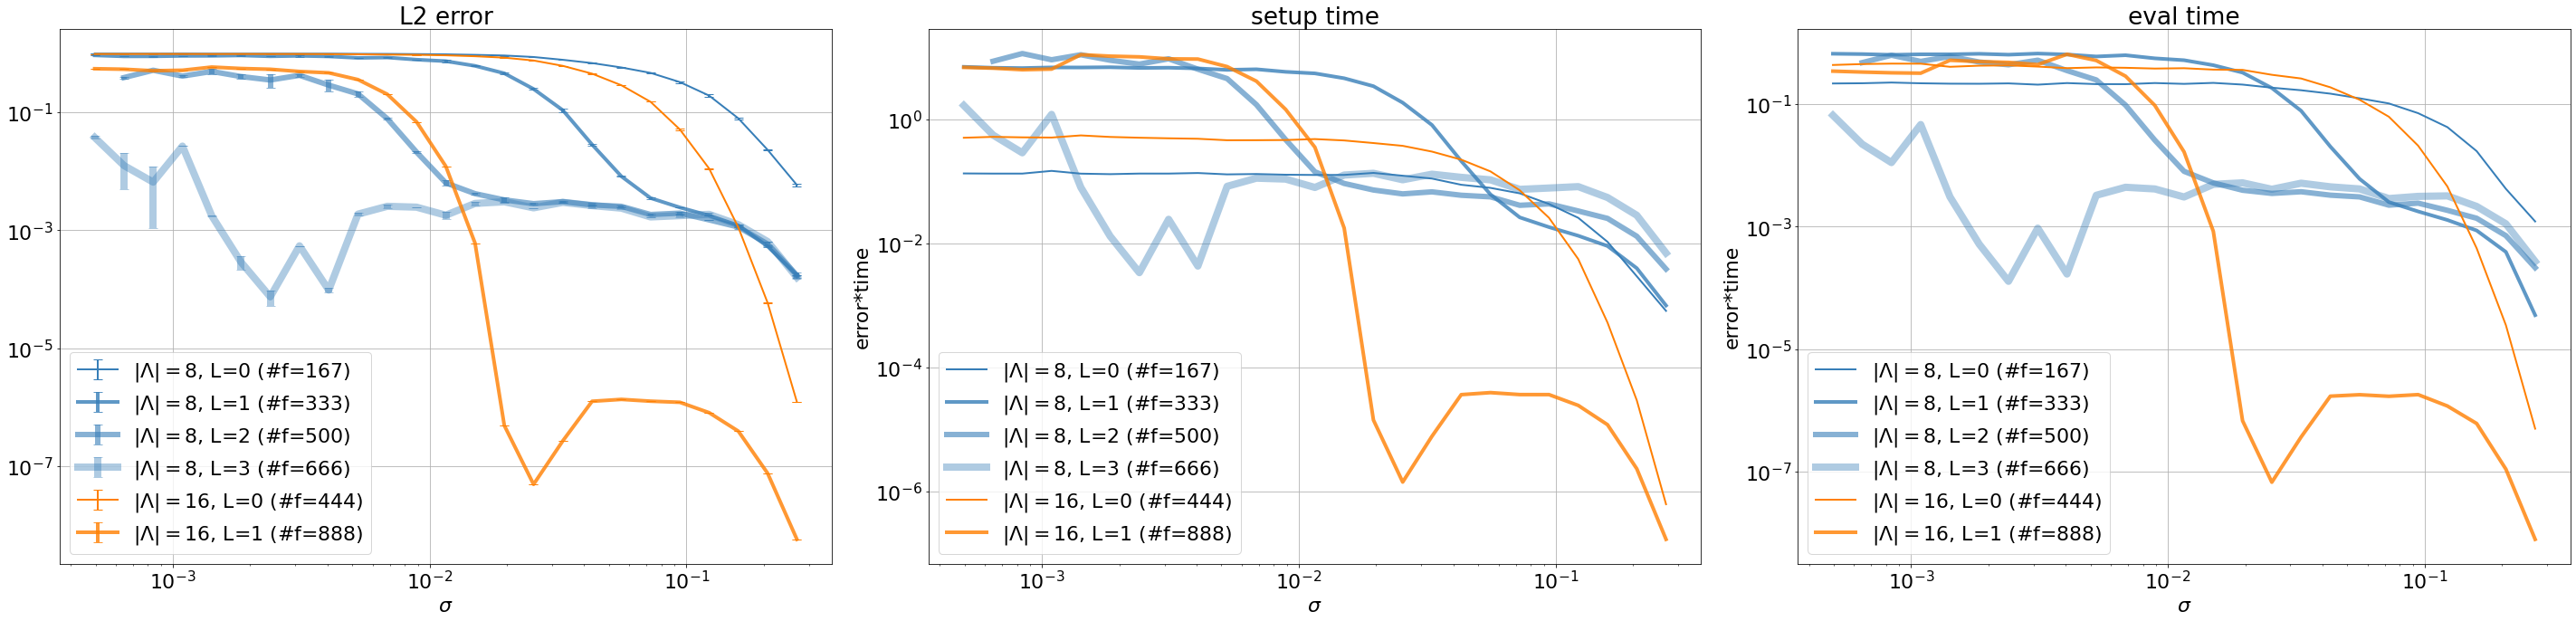

In [4]:
plot_results(sigmas, eps_Ls, results_l2, results_st, results_et)

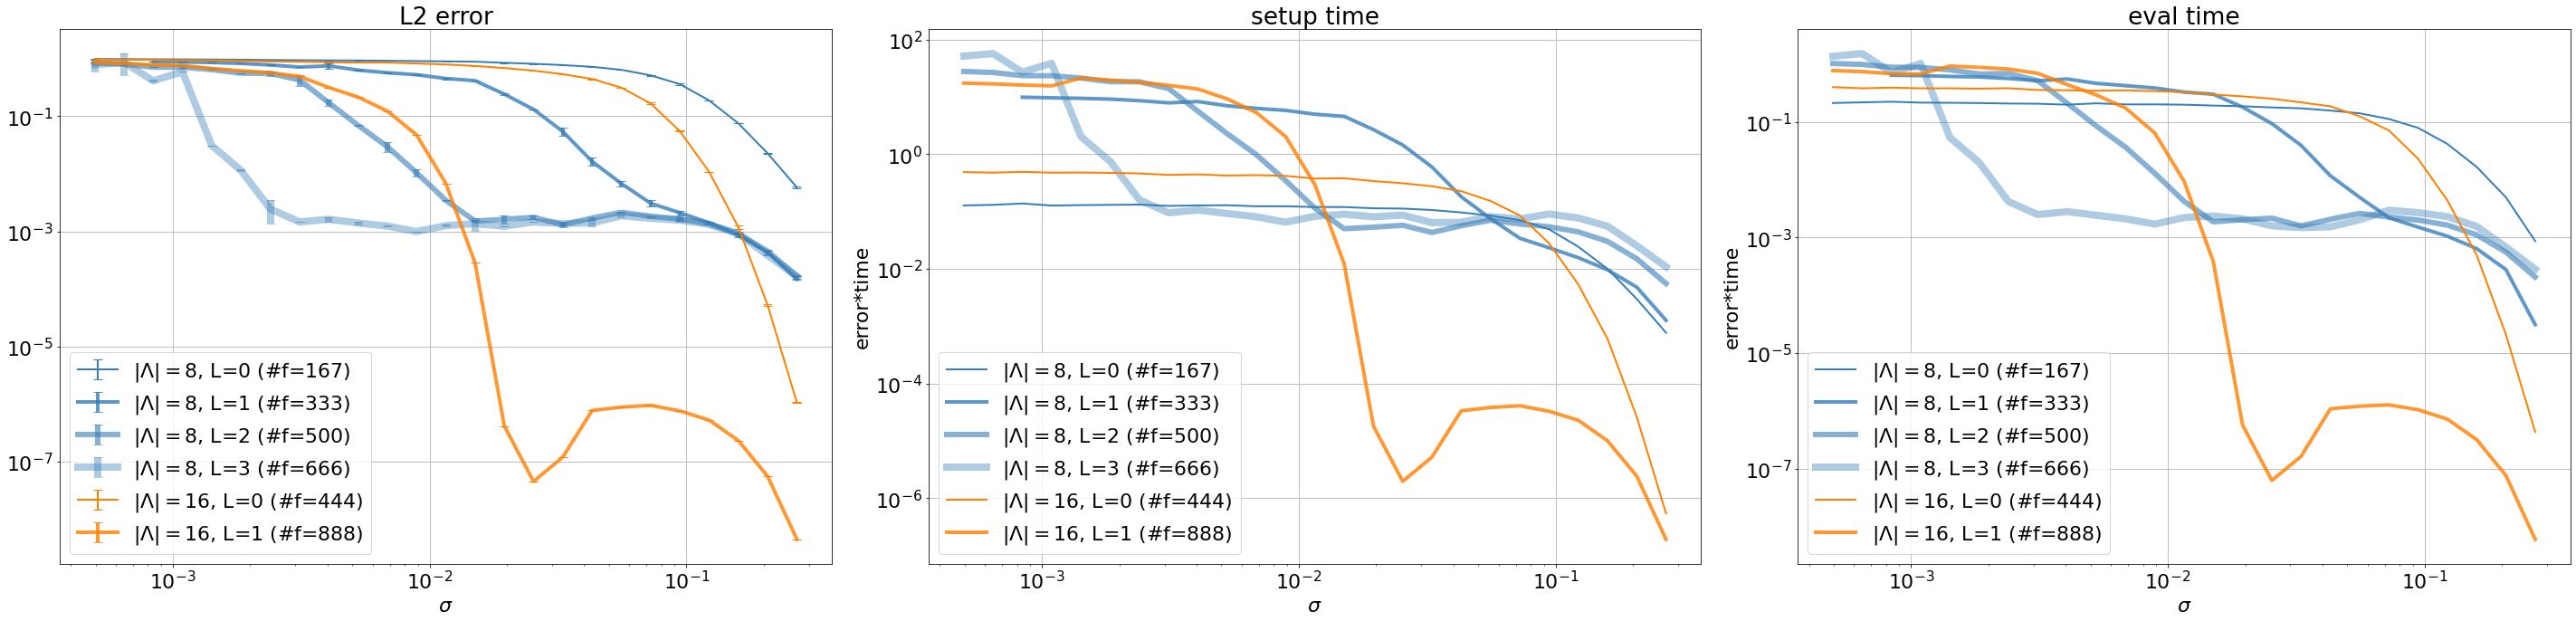

In [6]:
plot_results(sigmas, eps_Ls, results_l2, results_st, results_et)

In [5]:
n_runs = 2
n_samples = 200

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

sigmas = [1.3**(-i) for i in range(5,30)]
eps_Ls = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1) ] # {multi, L}
epslns = [.08, .004, .0002, .000015]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]

results_l2 = np.zeros((len(eps_Ls), len(sigmas), n_runs))
results_st = np.zeros((len(eps_Ls), len(sigmas), n_runs))
results_et = np.zeros((len(eps_Ls), len(sigmas), n_runs))

def compute(indices) :
    (i,j,k) = indices
    
    target = GaussianPosterior(noise=sigmas[j] , y_measurement=[.2])
    true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
    true_target /= np.sum(true_target)
    norm = np.sqrt(np.dot(true_target, true_target))
    
    multi = multis[eps_Ls[i][0]]
    temps = [10**(-eps_Ls[i][1]+n) for n in range(eps_Ls[i][1]+1)]
    
    start = time.process_time()
    deeptm = DeepTransportMapX(1, target, temps, multi, 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start
    
    print('i={}, j={}, k={}, m={}, temps: {}'.format(i,j,k, multi.Size(), temps))

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(eps_Ls))[::-1], range(len(sigmas))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

i=5, j=24, k=1, m=16, temps: [0.1, 1]
i=5, j=23, k=1, m=16, temps: [0.1, 1]
i=5, j=22, k=0, m=16, temps: [0.1, 1]
i=5, j=23, k=0, m=16, temps: [0.1, 1]
i=5, j=22, k=1, m=16, temps: [0.1, 1]
i=5, j=21, k=0, m=16, temps: [0.1, 1]
i=5, j=24, k=0, m=16, temps: [0.1, 1]
i=5, j=21, k=1, m=16, temps: [0.1, 1]
i=5, j=20, k=0, m=16, temps: [0.1, 1]
i=5, j=18, k=1, m=16, temps: [0.1, 1]
i=5, j=19, k=1, m=16, temps: [0.1, 1]
i=5, j=19, k=0, m=16, temps: [0.1, 1]i=5, j=17, k=0, m=16, temps: [0.1, 1]

i=5, j=18, k=0, m=16, temps: [0.1, 1]
i=5, j=20, k=1, m=16, temps: [0.1, 1]
i=5, j=17, k=1, m=16, temps: [0.1, 1]
i=5, j=15, k=1, m=16, temps: [0.1, 1]
i=5, j=16, k=0, m=16, temps: [0.1, 1]
i=5, j=15, k=0, m=16, temps: [0.1, 1]
i=5, j=14, k=1, m=16, temps: [0.1, 1]
i=5, j=13, k=1, m=16, temps: [0.1, 1]
i=5, j=13, k=0, m=16, temps: [0.1, 1]
i=5, j=16, k=1, m=16, temps: [0.1, 1]
i=5, j=14, k=0, m=16, temps: [0.1, 1]
i=5, j=12, k=0, m=16, temps: [0.1, 1]
i=5, j=12, k=1, m=16, temps: [0.1, 1]
i=5, j=11, k

/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1
/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


i=2, j=3, k=0, m=8, temps: [0.01, 0.1, 1]


/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1


i=2, j=2, k=1, m=8, temps: [0.01, 0.1, 1]
i=2, j=2, k=0, m=8, temps: [0.01, 0.1, 1]


/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1
/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


i=1, j=24, k=1, m=8, temps: [0.1, 1]
i=2, j=1, k=0, m=8, temps: [0.01, 0.1, 1]
i=2, j=1, k=1, m=8, temps: [0.01, 0.1, 1]


/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


i=1, j=24, k=0, m=8, temps: [0.1, 1]
i=1, j=23, k=1, m=8, temps: [0.1, 1]
i=1, j=23, k=0, m=8, temps: [0.1, 1]
i=2, j=0, k=1, m=8, temps: [0.01, 0.1, 1]
i=1, j=22, k=1, m=8, temps: [0.1, 1]
i=1, j=22, k=0, m=8, temps: [0.1, 1]
i=2, j=0, k=0, m=8, temps: [0.01, 0.1, 1]
i=1, j=21, k=1, m=8, temps: [0.1, 1]
i=1, j=21, k=0, m=8, temps: [0.1, 1]
i=1, j=20, k=1, m=8, temps: [0.1, 1]
i=1, j=19, k=1, m=8, temps: [0.1, 1]
i=1, j=20, k=0, m=8, temps: [0.1, 1]
i=1, j=18, k=1, m=8, temps: [0.1, 1]
i=1, j=19, k=0, m=8, temps: [0.1, 1]
i=1, j=18, k=0, m=8, temps: [0.1, 1]
i=1, j=17, k=1, m=8, temps: [0.1, 1]
i=1, j=17, k=0, m=8, temps: [0.1, 1]
i=1, j=15, k=1, m=8, temps: [0.1, 1]
i=1, j=16, k=1, m=8, temps: [0.1, 1]
i=1, j=16, k=0, m=8, temps: [0.1, 1]
i=1, j=15, k=0, m=8, temps: [0.1, 1]
i=1, j=14, k=0, m=8, temps: [0.1, 1]
i=1, j=14, k=1, m=8, temps: [0.1, 1]
i=1, j=13, k=1, m=8, temps: [0.1, 1]
i=1, j=13, k=0, m=8, temps: [0.1, 1]
i=1, j=11, k=1, m=8, temps: [0.1, 1]
i=1, j=12, k=1, m=8, temps: 